# Assessment 3 - Option 2: Tree and Ensemble Learning
Objective: Analyse the Abalone data set using decision trees, random forests, and ensemble learning to predict age using other data features.

"Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem."
Source http://archive.ics.uci.edu/ml/datasets/Abalone

Data set format:
Name / Data Type / Measurement Unit / Description

Sex / nominal / -- / M, F,  and I (infant)
Length / continuous / mm / Longest shell measurement
Diameter / continuous / mm / perpendicular to length
Height / continuous / mm / with meat in shell
Whole weight / continuous / grams / whole abalone
Shucked weight / continuous / grams / weight of meat
Viscera weight / continuous / grams / gut weight (after bleeding)
Shell weight / continuous / grams / after being dried
Rings / integer / -- / gives the age in years

Data transformations:
To assist with classifying age, the original data will be broken into 4 classe:
- Class 1: 0-7 years
- Class 2: 7-10 years
- Class 3: 11-15 years
- Class 4: >15 years

## Steps
1. Visualise the data set and provide initial commentary/analysis.
2. Clean the data set (if necessary).
3. Apply the CART model to the problem and report performance (classification accuracy or F1 score) on train and test sets.
4. Attempt to improve performance by pre-pruning or post-pruning the tree.
5. Apply bagging of trees via random forest and report performance on train and test sets as number of trees increases.
6. For both the CART and bagging models, run 2-10 experiments with different parameters/hyper-parameters to search for a more optimal model. Report results, including performance accuracy, mean, and confidence interval.

## Step 1 - Visualise and Analyse data set

In [266]:
# Semi-source: https://www.geeksforgeeks.org/decision-tree-implementation-python/

# Suppress all sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Import needed packages
import numpy as np 
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeClassifier, DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix
import scipy.stats as st

In [267]:
# Initialise global variables/hyper-parameters and set seed for reproducibility
TEST_PERCENT = 0.25
EXPERIMENT = 42
MAX_DEPTH = 5
MIN_SAMPLES = 100
N_ESTIMATORS = 5
MAX_FEATURES = 3
random_state = np.random.RandomState(seed=EXPERIMENT)

In [268]:
# Function importing data set 
labels = ['Sex','Length','Diameter','Height', \
'Whole Weight','Shucked Weight','Viscera Weight','Shell Weight', 'Rings (Age)']

abalone_data = pd.read_csv('./data/abalone.data', header=None)
abalone_data.columns = labels

# Having an initial look at the data
print(f"Data set preview: \n{abalone_data.head()}\n")
print(f"Feature information: \n{abalone_data.info()}\n")
print(f"Feature distribution: \n{abalone_data.describe()}\n")

### LATEX FORMAT
print(abalone_data.head().to_latex(index=False))
print(pd.DataFrame(abalone_data.info()).to_latex(index=False))
print(pd.DataFrame(abalone_data.describe()).to_latex(index=False))

Data set preview: 
  Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  Viscera Weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell Weight  Rings (Age)  
0         0.150           15  
1         0.070            7  
2         0.210            9  
3         0.155           10  
4         0.055            7  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        

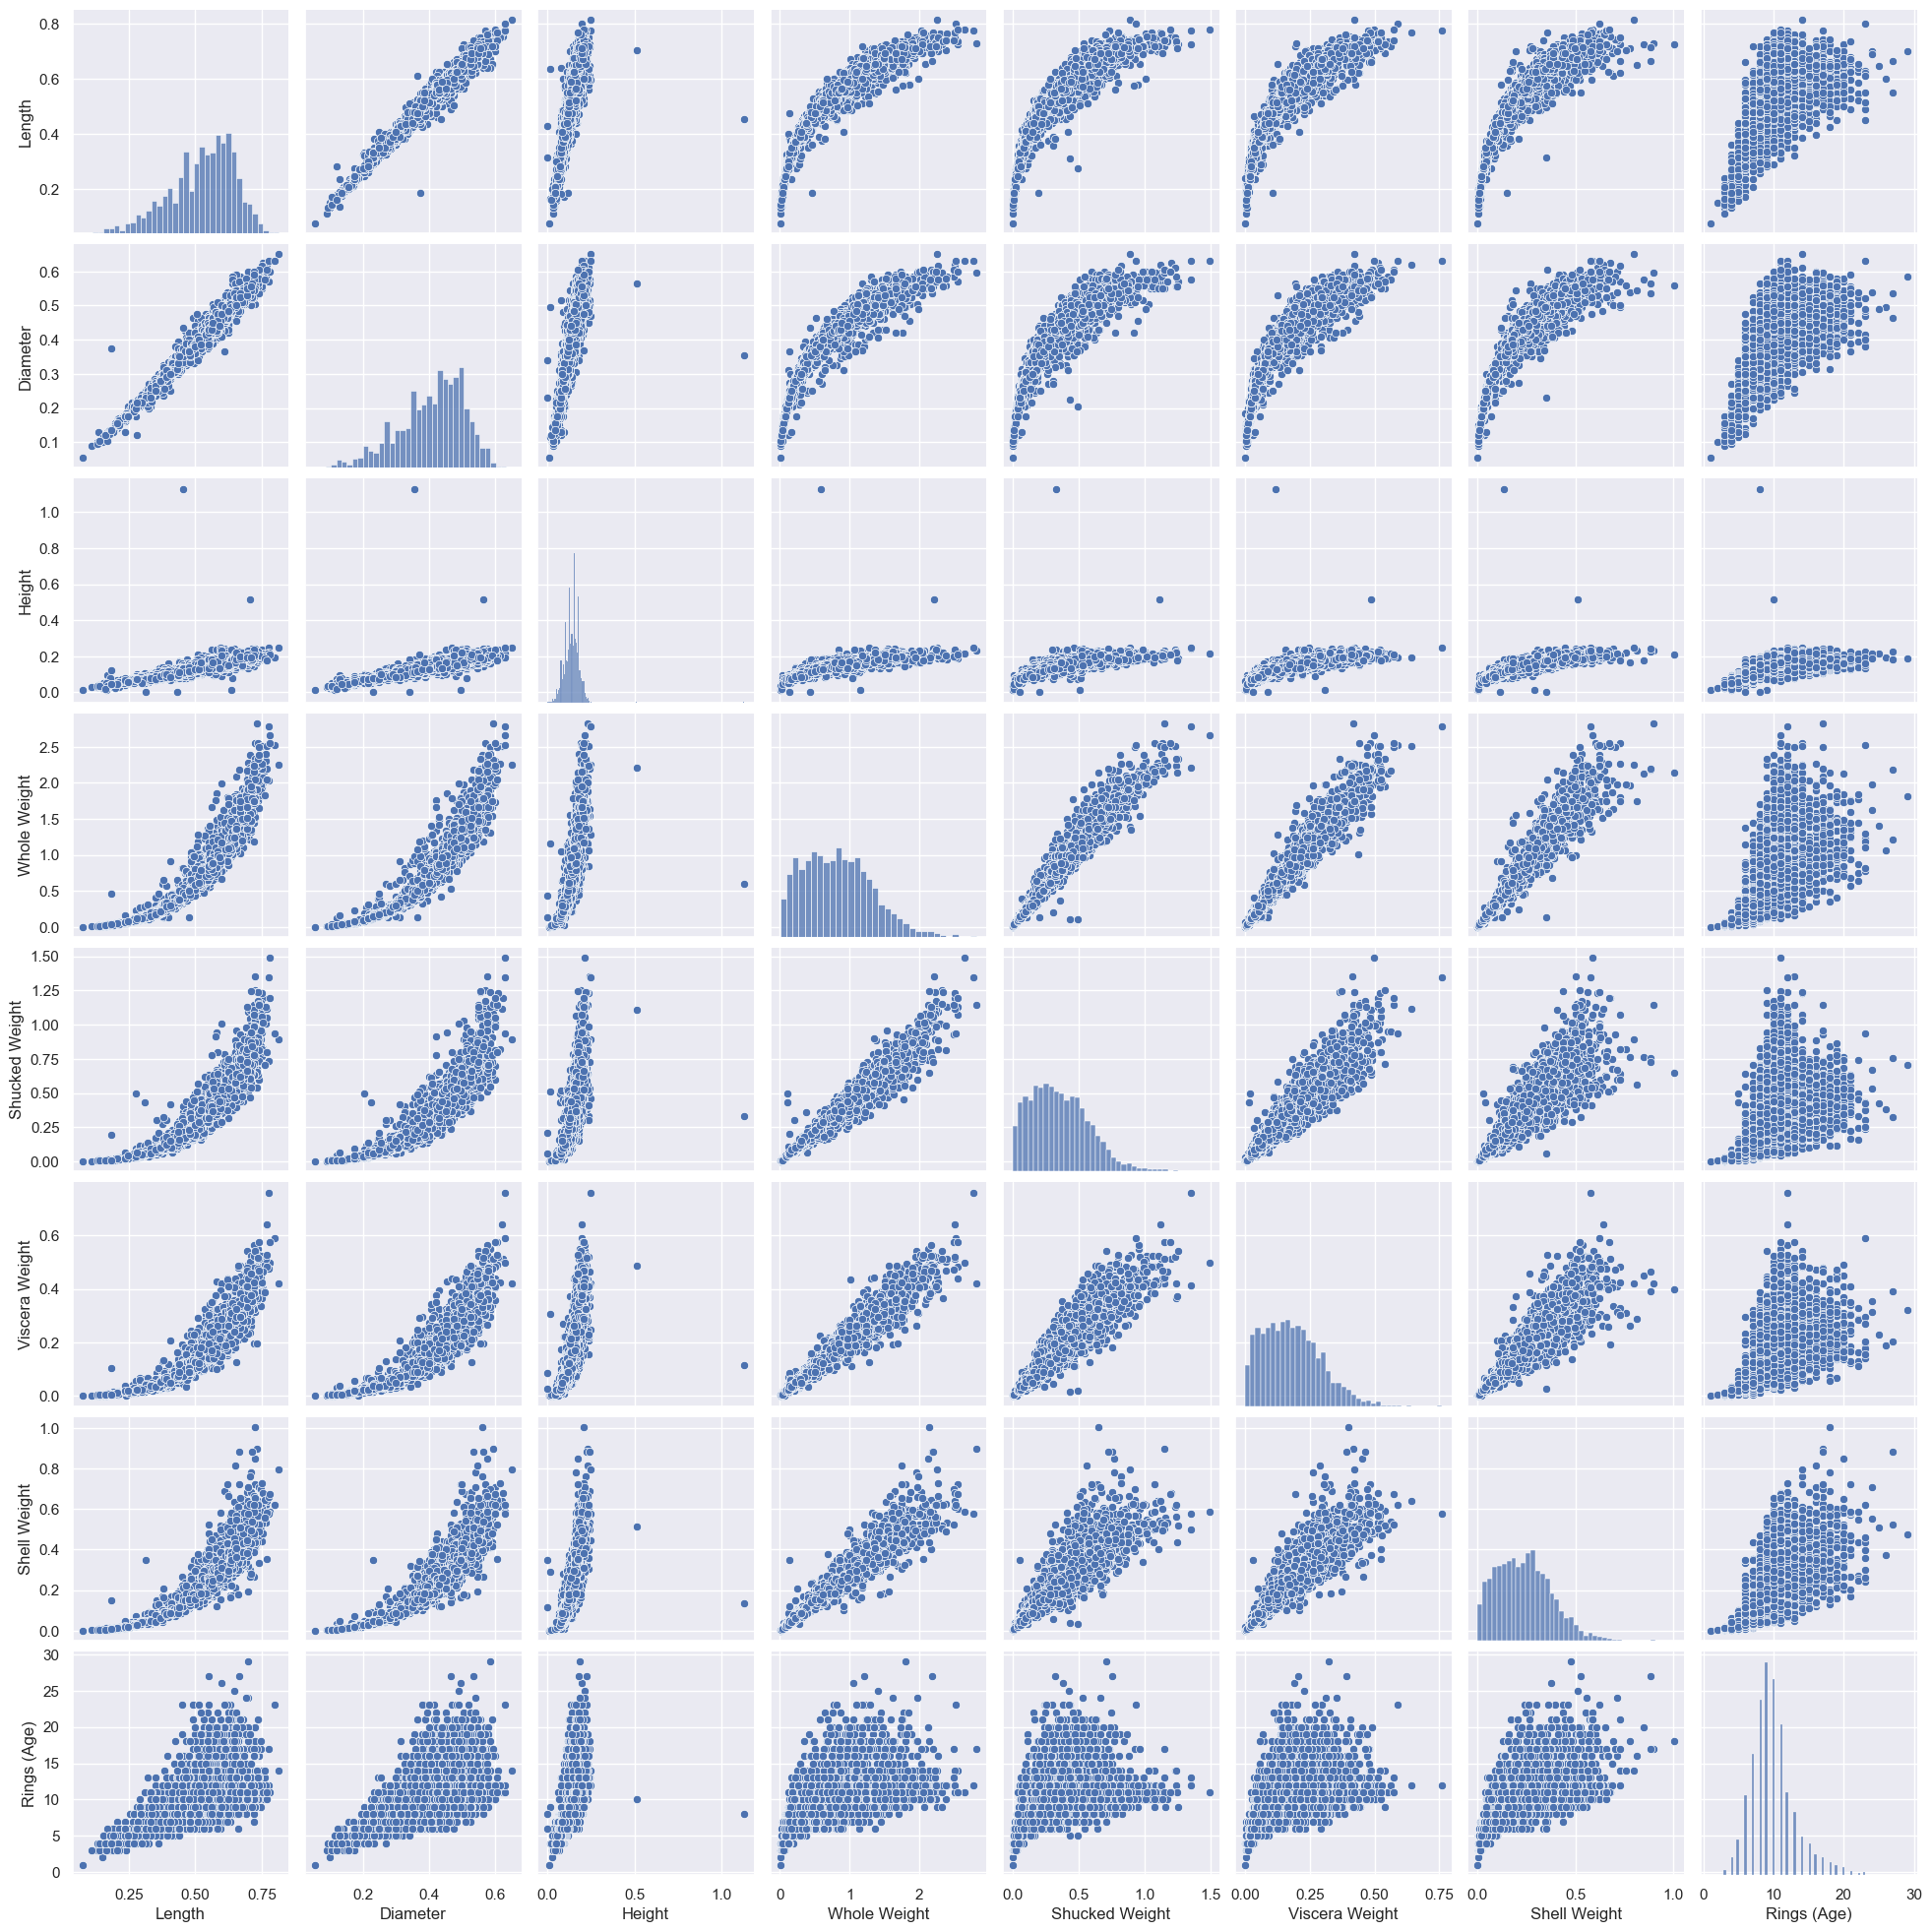

<Figure size 500x500 with 0 Axes>

In [269]:
# Visualise the data
sb.set(rc = {'figure.figsize':(5,5)})
sb.pairplot(data=abalone_data, palette='rocket')
plt.show()
plt.clf()

## Step 2 - Clean the data set
Sci-kit Learn's implementation of CART does not allow for categorical variables, so the 'Sex' feature will be converted as follows:
Male (M) -> 0
Female (F) -> 1
Infant(I) -> -1

No further cleansing is needed at this stage. Normalisation May be performed later if needed.

In [270]:
# Clump the 'Age' feature to match the classification task
abalone_data["new 1"] = np.where(abalone_data['Rings (Age)'] <= 7, 1, 0)
abalone_data["new 2"] = np.where(((abalone_data['Rings (Age)'] > 7) & (abalone_data['Rings (Age)'] <= 10)), 2, 0)
abalone_data["new 3"] = np.where(((abalone_data['Rings (Age)'] > 10) & (abalone_data['Rings (Age)'] <= 15)), 3, 0)
abalone_data["new 4"] = np.where(abalone_data['Rings (Age)'] > 15, 4, 0)
abalone_data["Age by Class"] = abalone_data["new 1"] + \
    abalone_data["new 2"] + abalone_data["new 3"] + abalone_data["new 4"]

abalone_data = abalone_data.drop(['Rings (Age)', 'new 1', 'new 2', 'new 3', 'new 4'], axis=1)

# Convert the 'Sex' feature to numeric
abalone_data.iloc[:,0] = abalone_data.iloc[:,0].replace(['M','F','I'],[0,1,-1])

# Having a look at the transformed data
print(f"Transformed data set preview: \n{abalone_data.head()}\n")
print(f"Transformed feature information: \n{abalone_data.info()}\n")
print(f"Transofrmed feature distribution: \n{abalone_data.describe()}\n")


Transformed data set preview: 
   Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  \
0    0   0.455     0.365   0.095        0.5140          0.2245   
1    0   0.350     0.265   0.090        0.2255          0.0995   
2    1   0.530     0.420   0.135        0.6770          0.2565   
3    0   0.440     0.365   0.125        0.5160          0.2155   
4   -1   0.330     0.255   0.080        0.2050          0.0895   

   Viscera Weight  Shell Weight  Age by Class  
0          0.1010         0.150             3  
1          0.0485         0.070             1  
2          0.1415         0.210             2  
3          0.1140         0.155             2  
4          0.0395         0.055             1  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   int64  
 1   Length          4177 non-null   float

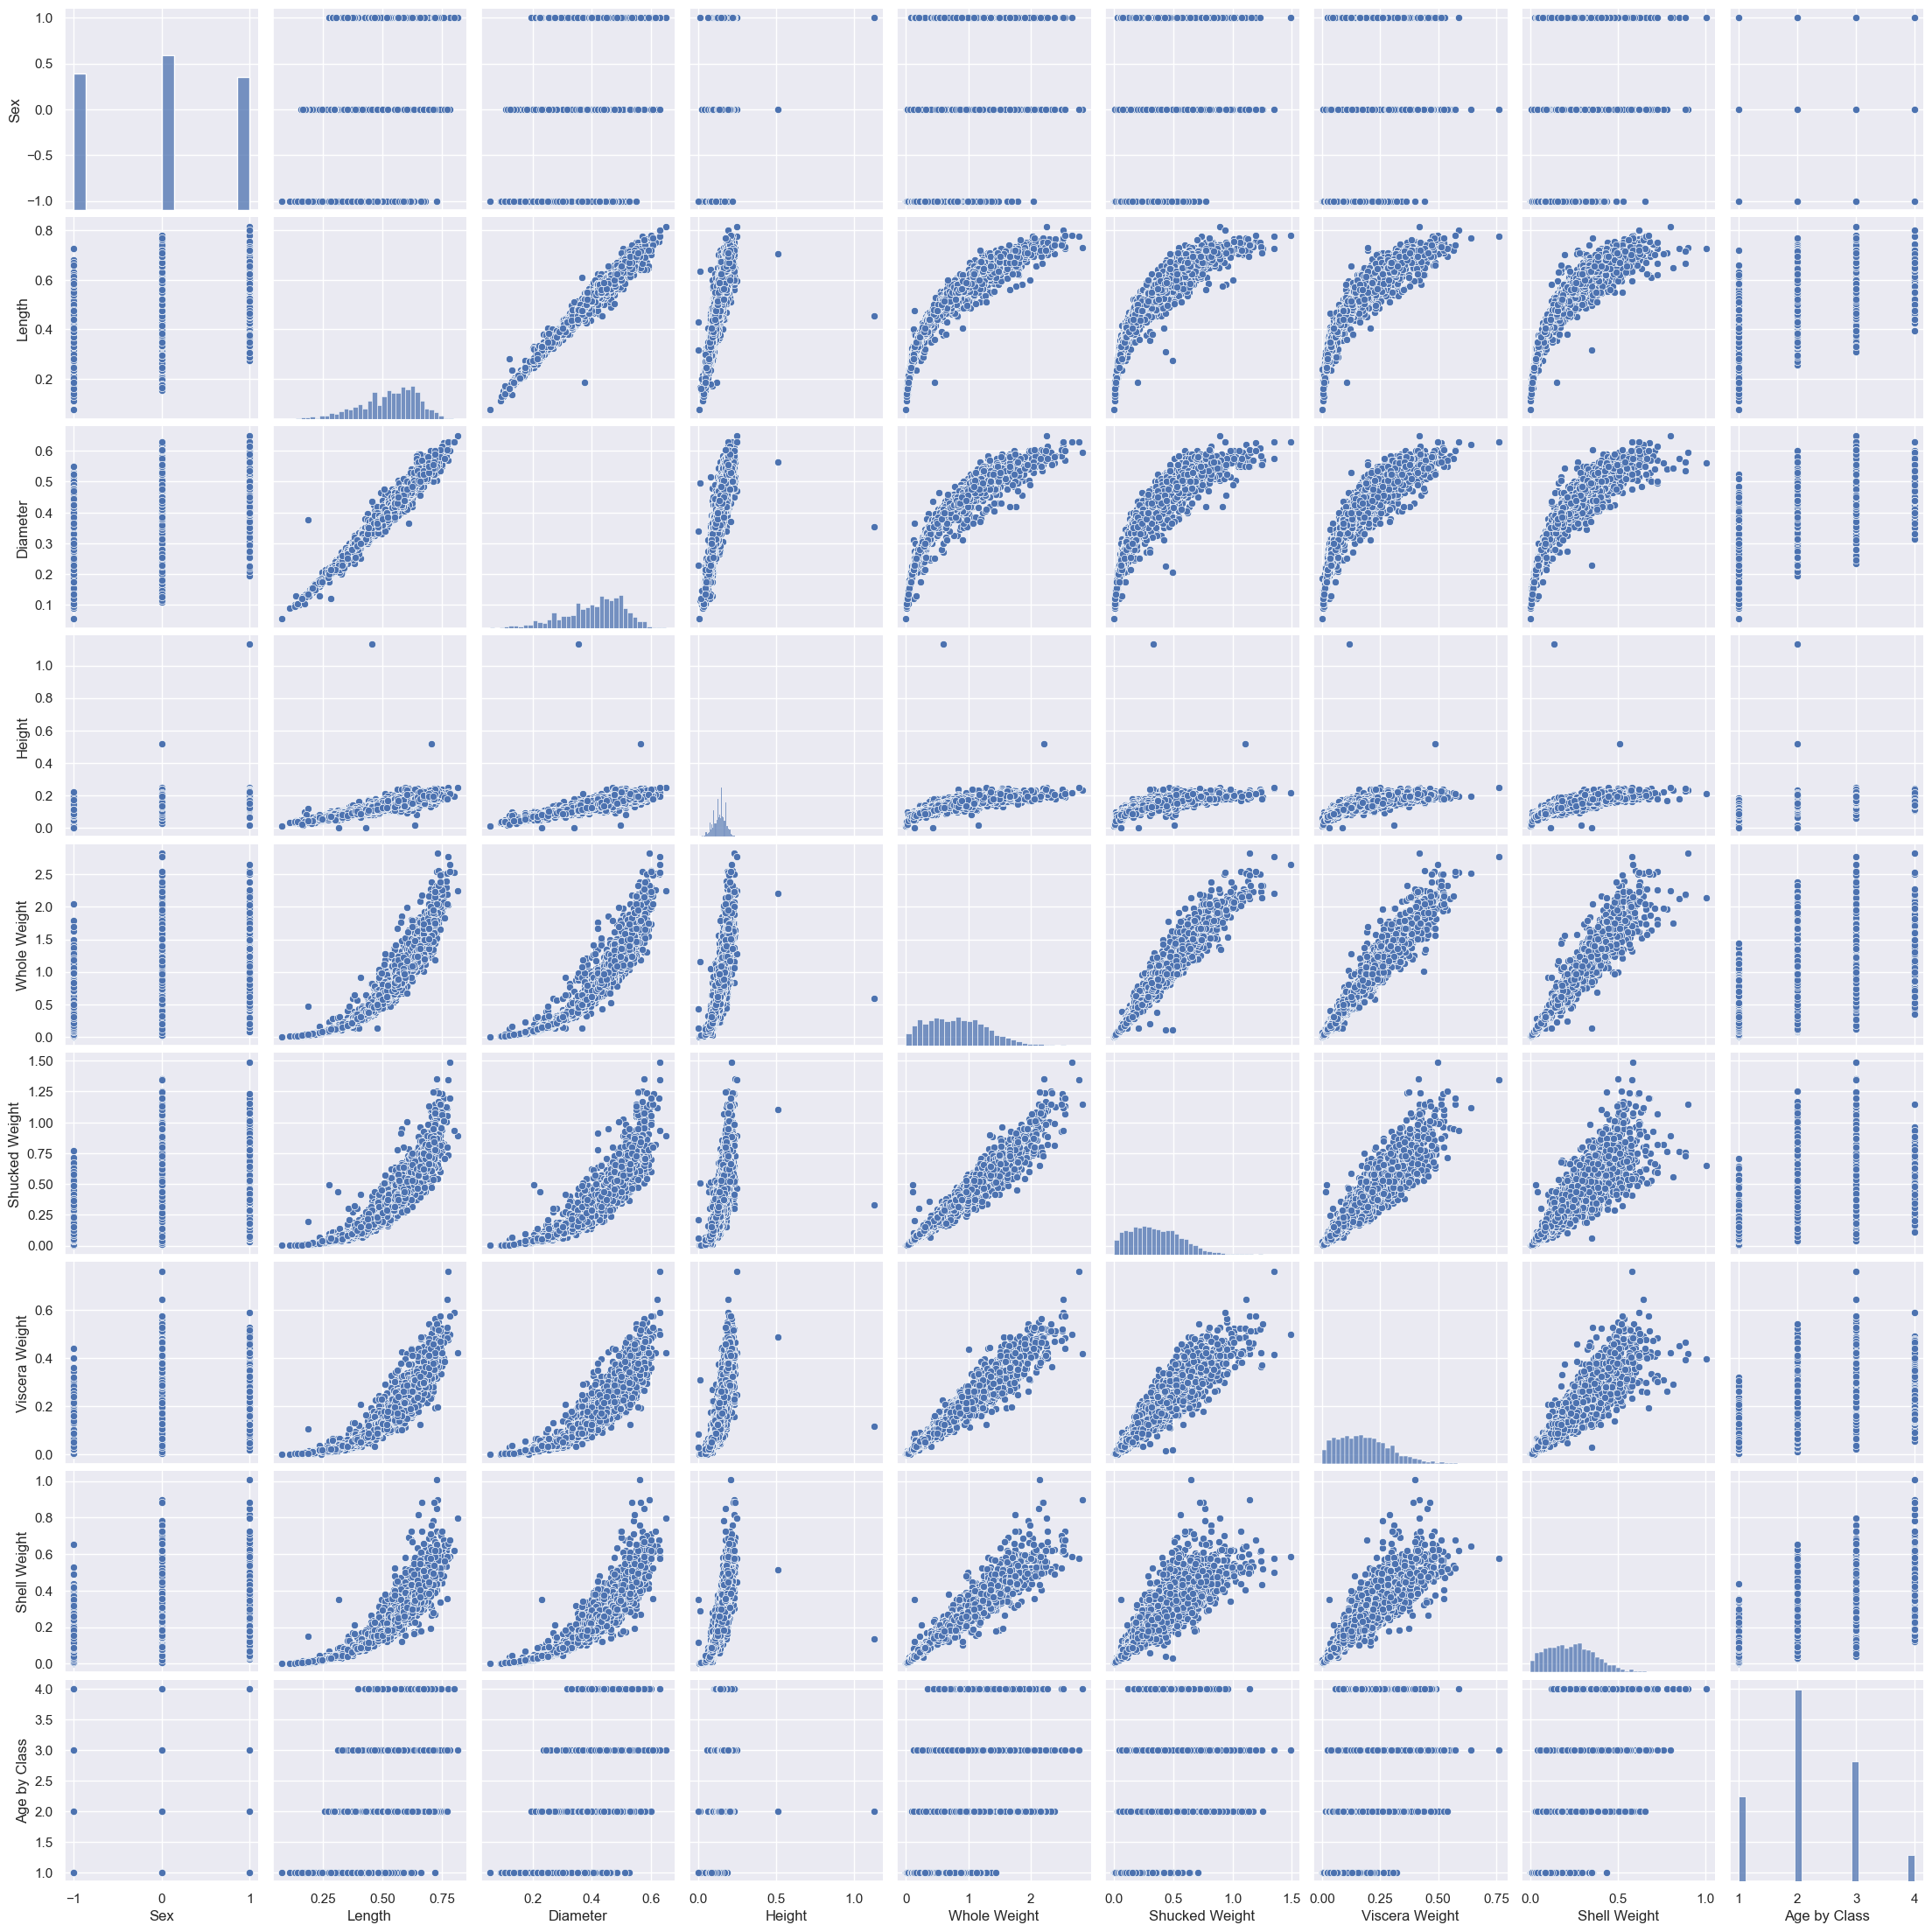

<Figure size 1500x1000 with 0 Axes>

In [282]:
# Re-visualise the data
sb.set(rc = {'figure.figsize':(15,10)})
sb.pairplot(data=abalone_data, palette='rocket')
plt.savefig('modified_pairplot.png')
plt.show()
plt.clf()

In [285]:
# Now we carve the data up into the dependent and independent features
x = abalone_data.iloc[:,0:8]
y = abalone_data.iloc[:,-1]

print(f"Count of different class values for age: \n{y.value_counts()}")

### LATEX FORMAT
print(y.value_counts().to_latex())

Count of different class values for age: 
2    1891
3    1186
1     839
4     261
Name: Age by Class, dtype: int64
\begin{tabular}{lr}
\toprule
{} &  Age by Class \\
\midrule
2 &          1891 \\
3 &          1186 \\
1 &           839 \\
4 &           261 \\
\bottomrule
\end{tabular}



In [273]:
# Split the data set into training and testing
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=TEST_PERCENT, random_state=random_state
)

# Check the class imbalance in y_train and y_test
print(f"y_train value count: \n{y_train.value_counts()}")
print(f"y_test value count: \n{y_test.value_counts()}")

y_train value count: 
2    1421
3     904
1     610
4     197
Name: Age by Class, dtype: int64
y_test value count: 
2    470
3    282
1    229
4     64
Name: Age by Class, dtype: int64


## Step 3 - Apply the CART Model and Report Performance

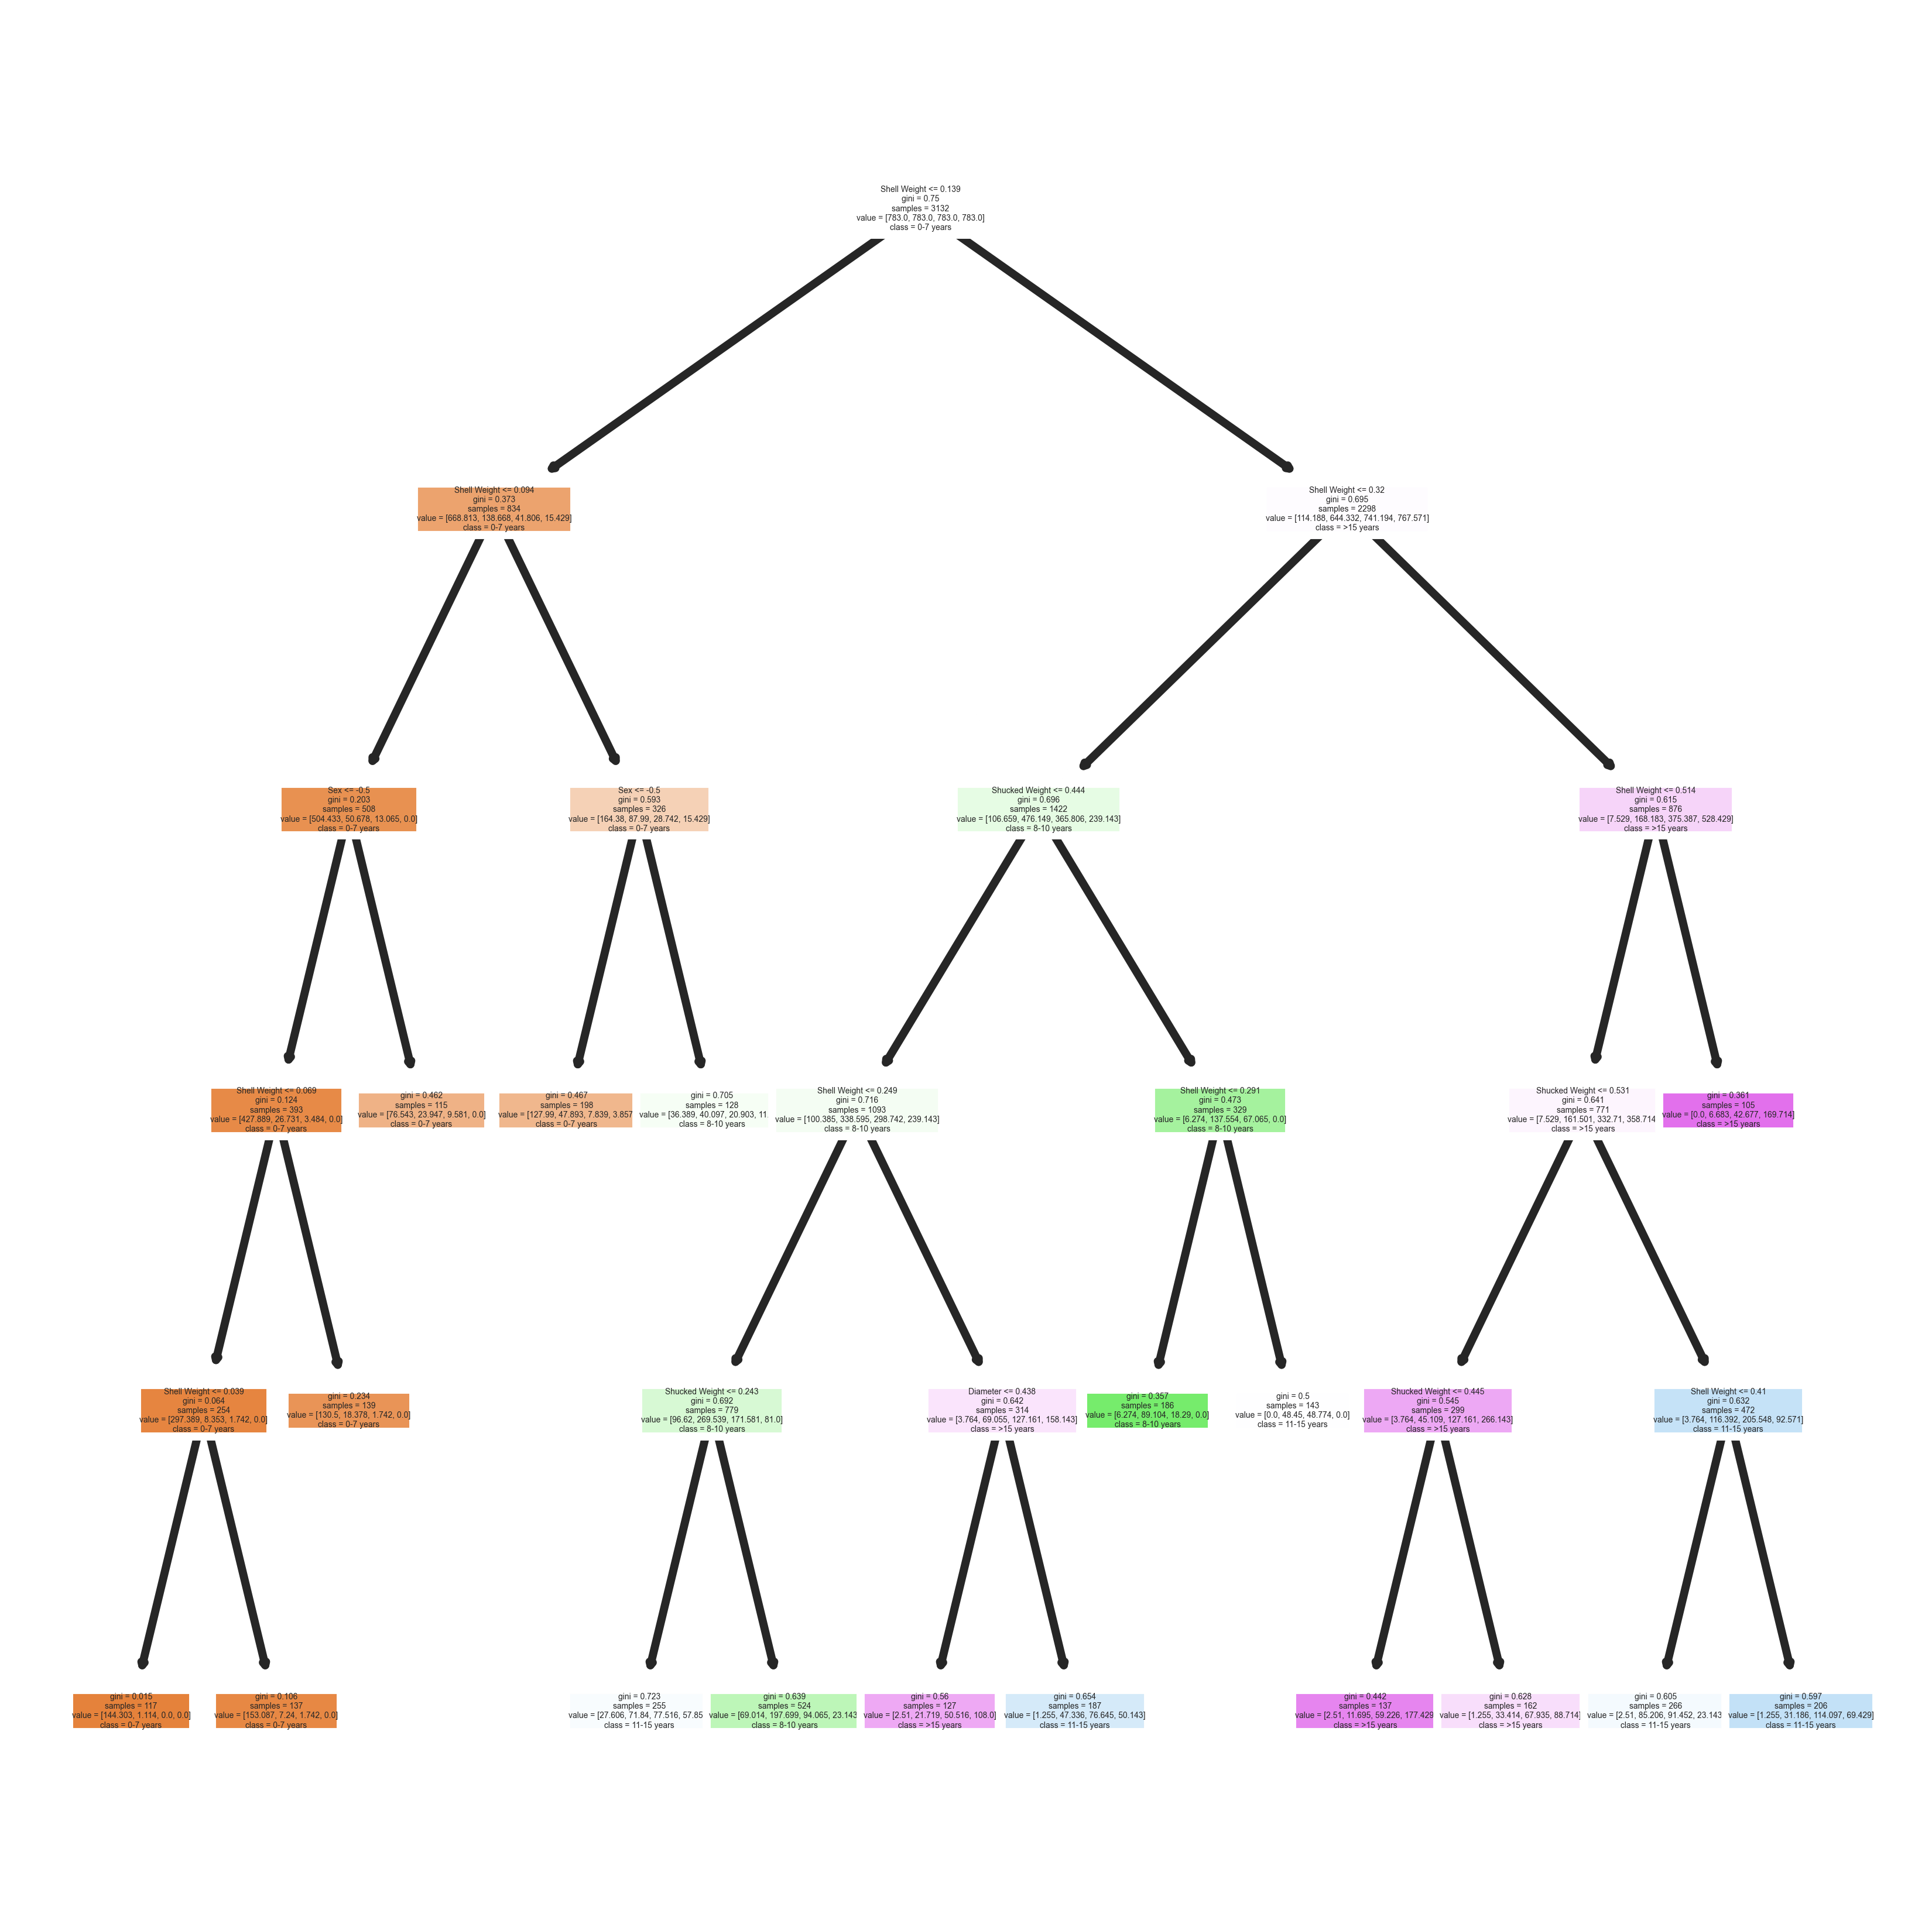

CART model parameters: 
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': RandomState(MT19937) at 0x2BB4B5340, 'splitter': 'best'}

CART model train score: 
0.5431034482758621

CART model test score: 
0.5483253588516747

CART model classification report: 
              precision    recall  f1-score   support

           1       0.69      0.82      0.75       215
           2       0.72      0.45      0.56       485
           3       0.44      0.50      0.47       287
           4       0.21      0.57      0.31        58

    accuracy                           0.55      1045
   macro avg       0.51      0.59      0.52      1045
weighted avg       0.61      0.55      0.56      1045


CART model confusion report: 
[[177  30   7   1]
 [ 72 219 155  39]
 [  9  52 144  82]
 [  0   2  23

In [ ]:
# Create the classifier
cart_1 = DecisionTreeClassifier(
    random_state=random_state,
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES,
    class_weight="balanced")  # To automatically account for class imbalance in age

# Fit the model
cart_1.fit(x_train, y_train)

# Make predictions based on the test data
y_pred = cart_1.predict(x_test)

# Plot the tree
class_labels = ['0-7 years', '8-10 years', '11-15 years', '>15 years']
plt.figure(figsize=(4,4), dpi=1000)
plot_tree(cart_1, feature_names=labels, class_names=class_labels, filled=True)
plt.savefig('CART_tree.png')
plt.show()

# Output statistics
print(f"CART model parameters: \n{cart_1.get_params()}\n")
print(f"CART model train score: \n{cart_1.score(x_train, y_train)}\n")
print(f"CART model test score: \n{cart_1.score(x_test, y_test)}\n")
print(f"CART model classification report: \n{classification_report(y_test, y_pred)}\n")
print(f"CART model confusion report: \n{confusion_matrix(y_test, y_pred)}")

### LATEX FORMAT

In [275]:
# Check on y pred and y test
print(f"y_test: {y_test}")
print(f"y_test value count: \n{y_test.value_counts()}")
print(f"y_pred: {y_pred}")
print(f"y_pred value count: \n{pd.DataFrame(y_pred).value_counts()}")

y_test: 866     2
1483    2
599     4
1702    2
670     3
       ..
532     3
3417    2
1505    2
2245    2
2428    2
Name: Age by Class, Length: 1045, dtype: int64
y_test value count: 
2    470
3    282
1    229
4     64
Name: Age by Class, dtype: int64
y_pred: [3 2 3 ... 3 3 2]
y_pred value count: 
2    314
1    296
3    291
4    144
dtype: int64


In [276]:
# Check on x data and y data
print(f"x train: \n{x_train.to_string()}\n")
print(f"y train: \n{y_train.to_string()}\n")
print(f"x test: \n{x_test.to_string()}\n")
print(f"y test: \n{y_test.to_string()}\n")

x train: 
      Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  Viscera Weight  Shell Weight
3823    1   0.615     0.455   0.135        1.0590          0.4735          0.2630        0.2740
3956    1   0.515     0.395   0.140        0.6860          0.2810          0.1255        0.2200
3623    0   0.660     0.530   0.175        1.5830          0.7395          0.3505        0.4050
0       0   0.455     0.365   0.095        0.5140          0.2245          0.1010        0.1500
2183    0   0.495     0.400   0.155        0.8085          0.2345          0.1155        0.3500
4091    0   0.625     0.500   0.180        1.3705          0.6450          0.3030        0.3705
2042   -1   0.385     0.280   0.100        0.2755          0.1305          0.0610        0.0725
1075   -1   0.410     0.325   0.100        0.3245          0.1320          0.0720        0.1060
247    -1   0.360     0.275   0.085        0.1975          0.0745          0.0415        0.0700
1461    0   0.485     0.370   

## Step 4 - Attempt to improve performance by pre and/or post pruning

In [277]:
# Perform a grid search to look for a better model (pre-pruning/early stopping)
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=random_state, class_weight="balanced"),
    param_grid=ParameterGrid(
        {
            "min_samples_leaf": [[split] for split in np.arange(10, 200, 5)],
            "max_depth": [[depth] for depth in np.arange(1, 30, 1)]
        }
    )
)

# Fit the model
grid_search.fit(x_train, y_train)

# Print the best estimator
print(f"Best estimator: \n{grid_search.best_estimator_}\n")

#Create a tree 
best_tree = grid_search.best_estimator_
y_pred_search = best_tree.predict(x_test)
print(f"Search model train score: \n{best_tree.score(x_train, y_train)}\n")
print(f"Search model test score: \n{best_tree.score(x_test, y_test)}\n")

Best estimator: 
DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10,
                       random_state=RandomState(MT19937) at 0x2BD6FF340)

Search model train score: 
0.6698595146871009

Search model test score: 
0.5607655502392345



## Step 5 - Random Forest
First we'll try a guess at a random forest with 5 estimators, then we'll try a grid search for how many trees performs the best.

In [278]:
# Set up the random forest
random_forest = RandomForestClassifier(
    random_state=random_state,
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES,
    max_features=MAX_FEATURES,
    class_weight="balanced")
random_forest.fit(x_train, y_train)
y_pred_forest = random_forest.predict(x_test)

# Output statistics
print(f"Forest model parameters: \n{random_forest.get_params()}\n")
print(f"Forest model train score: \n{random_forest.score(x_train, y_train)}\n")
print(f"Forest model test score: \n{random_forest.score(x_test, y_test)}\n")
#print(f'CART model test RMSE: \n{mean_squared_error(y_test, y_pred, squared=False)}\n')
print(f"Forest model classification report: \n{classification_report(y_test, y_pred_forest)}")
print(f"Forest model confusion report: \n{confusion_matrix(y_test, y_pred_forest)}")

Forest model parameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 100, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5, 'n_jobs': None, 'oob_score': False, 'random_state': RandomState(MT19937) at 0x2BCDE2940, 'verbose': 0, 'warm_start': False}

Forest model train score: 
0.5561941251596424

Forest model test score: 
0.5511961722488038

Forest model classification report: 
              precision    recall  f1-score   support

           1       0.71      0.87      0.78       229
           2       0.65      0.54      0.59       470
           3       0.42      0.29      0.34       282
           4       0.23      0.62      0.34        64

    accuracy                           0.55      1045
   macro avg       0.50      0.58      0.51      1045
weighted avg       0.57      0.55      0.

In [279]:
# Try a grid search for the best number of estimators in the random forest
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=random_state, class_weight="balanced"),
    param_grid=ParameterGrid(
        {
            "n_estimators": [[n] for n in np.arange(1, 50, 1)]
        }
    )
)

# Fit the model
grid_search_rf.fit(x_train, y_train)

# Print the best estimator
print(f"Best estimator: \n{grid_search_rf.best_estimator_}\n")

#Create a tree 
best_trees = grid_search_rf.best_estimator_
y_pred_rfsearch = best_trees.predict(x_test)
print(f"Search model train score: \n{best_trees.score(x_train, y_train)}\n")
print(f"Search model test score: \n{best_trees.score(x_test, y_test)}\n")

Best estimator: 
RandomForestClassifier(class_weight='balanced', n_estimators=44,
                       random_state=RandomState(MT19937) at 0x2BCDE2440)

Search model train score: 
1.0

Search model test score: 
0.6497607655502392



## Step 6 - Run 10 experiments for both the CART and bagging models

In [280]:
cart_train_scores = []
cart_test_scores = []
rf_train_scores = []
rf_test_scores = []

# Cycle through 10 experiments (different sata sets) for each
for exp in np.arange(1,11,1):
    random_state = np.random.RandomState(seed=exp)

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=TEST_PERCENT, random_state=random_state
    )

    # The original CART specification that had the best test score
    cart_experiment = DecisionTreeClassifier(random_state=random_state,
    max_depth=6,
    min_samples_leaf=60,
    class_weight="balanced")

    cart_experiment.fit(x_train, y_train)

    cart_train_scores.append(cart_experiment.score(x_train, y_train))
    cart_test_scores.append(cart_experiment.score(x_test, y_test))

    # Random forest using the best model using grid search
    rf_experiment = RandomForestClassifier(
        n_estimators=43, random_state=random_state,
        class_weight="balanced")
    
    rf_experiment.fit(x_train, y_train)

    rf_train_scores.append(rf_experiment.score(x_train, y_train))
    rf_test_scores.append(rf_experiment.score(x_test, y_test))


In [281]:
# Print results of CART experiment
cart_test_scores = pd.DataFrame(cart_test_scores)
print(f"CART experiment summary: \n{cart_test_scores.describe()}\n")
cts_interval = st.t.interval(0.95, len(cart_test_scores)-1, loc=np.mean(cart_test_scores), scale=st.sem(cart_test_scores))
print(f"95% Confidence interval: \n{cts_interval}\n")

# Print results of Random Forest experiment
rf_test_scores = pd.DataFrame(rf_test_scores)
print(f"RF experiment summary: \n{rf_test_scores.describe()}\n")
rts_interval = st.t.interval(0.95, len(rf_test_scores)-1, loc=np.mean(rf_test_scores), scale=st.sem(rf_test_scores))
print(f"95% Confidence interval: \n{rts_interval}\n")

CART experiment summary: 
               0
count  10.000000
mean    0.535694
std     0.026206
min     0.506220
25%     0.514115
50%     0.530622
75%     0.547368
max     0.582775

95% Confidence interval: 
(array([0.51694711]), array([0.55444045]))

RF experiment summary: 
               0
count  10.000000
mean    0.620287
std     0.018522
min     0.598086
25%     0.609809
50%     0.616268
75%     0.625120
max     0.654545

95% Confidence interval: 
(array([0.60703747]), array([0.6335367]))

